<a href="https://colab.research.google.com/github/aisummoner/absCat/blob/main/absCat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## absCat
The purpose of this notebook is to make medical abstracts easier to read by allocting sentences into sections

The paper we are replicating (data source) is located at: https://arxiv.org/abs/1710.06071

Reading through the paper above we see the model architecture with best results is from the paper located at: https://arxiv.org/abs/1612.05251

## Confirm access to GPU


In [3]:
# !nvidia-smi -L

## Get Data
We will use dataset from research paper above using authors github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
#Check what files are in PubMed_20k_RCT_numbers_replaced_with_at_sign
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [6]:
# Start experiments with 20k dataset with @ sign replacing numbers
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
# Check all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data
> Visualize

Write a function to read in all the lines of a target text file

In [8]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [9]:
# Read in the training lines
train_lines = get_lines(data_dir+"train.txt") #read the lines with training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

The role of each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).

Different abstracts are separated by abstract ID's (lines beginning with ###) and newlines (\n).

Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.

Let's write a function to perform the following steps:

Take a target file of abstract samples.

Read the lines in the target file. For each line in the target 
file:

*   If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
* Keep count of the number of lines in a sample.
*  If the line begins with ```\n``` mark it as the end of an abstract sample.
*  Keep count of the total lines in a sample.
* Record the text before the ```\t``` as the label of the line.
* Record the text after the ```\t``` as the text of the line.
*Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
* "line_number" - the position of the line in the abstract (e.g. 3).
* "target" - the role of the line in the abstract (e.g. OBJECTIVE).
* "text" - the text of the line in the abstract.
* "total_lines" - the total lines in an abstract sample (e.g. 14).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.

Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

In [11]:
# the right code for below

def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [12]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another way of saying validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt") 
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 421 ms, sys: 93.7 ms, total: 515 ms
Wall time: 517 ms


In [13]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that the data is a formatted into a list of dictionaries, lets visualize it into a DataFrame

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Distribution of label counts
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

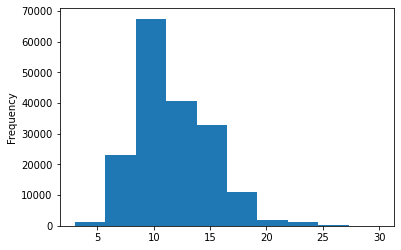

In [16]:
# Check length of different lines
train_df.total_lines.plot.hist();

## Get lists of sentences


In [17]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numberic labels (ML models require numberic labels)

In [19]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [20]:
# Extract lebels (target columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiements...
Trying out a bunch of models and seeing which works best
Starting with a baseline (TF-IDF Multinomial Naive Bayes classifier)

## Model 0: Getting a baseline

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions with baseline mdoel
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

## Download helper function script
from github url: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [25]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-11-02 00:47:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-02 00:47:24 (54.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [26]:
from helper_functions import calculate_results

In [27]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing text data for deep sequence models.
Must create vectorization and embedding layers.

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [29]:
# How long is each sentence on average?
"""With sentence data might want to add 0's or 
shorten words to have sentences same length since tensorflow like tensors to be in similar shape.
"""
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

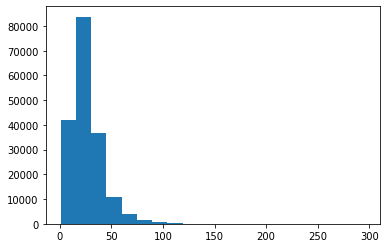

In [30]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);  # try differeint bin values to narrow results and find majority

In [31]:
# How long is sentence length in 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Maximum sentenct length in trianing set
max(sent_lens)

296

### Create text vectorization layer
Make a layer that maps text from words to numbers

In [33]:
# How many words are in the 20k data set vocab? from table 2: https://arxiv.org/pdf/1612.05251.pdf
max_tokens=68000

In [34]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,  # numbers of words in vocabulary
                                    output_sequence_length=output_seq_len)  # desired output length of vectorized sequences

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength: {len(target_sentence.split())}")
print(f"\nVectorizer: {text_vectorizer([target_sentence])}")

Text:
clinical assessment over a @-month period was performed .

Length: 9

Vectorizer: [[ 47 250 145   8 178 173  10 153   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [37]:
# How many words in training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

## Create custom text embedding

In [39]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # size of vocabulary
                               output_dim=128, # Note: different embedding sizes results in drastically different parameters to train
                               mask_zero=True, # Note: use masking to handle various sequenece lengths (save space)
                               name="token_embedding")

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorizatino:\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 clinical assessment over a @-month period was performed .

Sentence after vectorizatino:
 [[ 47 250 145   8 178 173  10 153   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
 [[[-0.01008733  0.03272586 -0.03588593 ...  0.03229341 -0.04180341
   -0.02983367]
  [ 0.03634861  0.00595263  0.04311652 ...  0.01246458 -0.02306968
   -0.00884341]
  [ 0.01632801 -0.00414406 -0.02809259 ...  0.01544494 -0.01533426
    0.0016629 ]
  ...
  [-0.04157154 -0.02064911 -0.02940919 ...  0.00451289 -0.04703867
   -0.00750402]
  [-0.04157154 -0.02064911 -0.02940919 ...  0.00451289 -0.04703867
   -0.00750402]
  [-0.04157154 -0.02064911 -0.02940919 ...  0.00451289 -0.04703867
   -0.00750402]]]

Embedded sentence shape: (1, 55, 128)


## Creating datasets that load as fast as possible
Setting up the data to run as fast as possbile with the Tensorflow tf.data API, information on creating these data pipelines is here:
* https://www.tensorflow.org/guide/data
* https://www.tensorflow.org/guide/data_performance




In [41]:
# Turn data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
train_labels_one_hot.shape

(180040, 5)

In [43]:
# Take TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # Don't need to shuffle because we want the model to learn order of sequences
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [44]:
# Create 1d conv model with sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x) # using softmax because there is multiclass classification
model_1 = tf.keras.Model(inputs, outputs)

# compile 
model_1.compile(loss="categorical_crossentropy", # categorial_crossentropy becuase dealing with multiclass
                optimizer=tf.keras.optimizers.Adam(), # can try stochaistic descent instead of Adam 
                metrics=["accuracy"])

In [45]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [46]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [47]:
len(train_dataset)

5627

In [48]:
5627*32

180064

In [49]:
# Fit the model. Goal is to find what doesn't work as fast as possible.
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), #taking 10% of training data to speed up model
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 0.9118 - accuracy: 0.6413 - val_loss: 0.6864 - val_accuracy: 0.7414
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6594 - accuracy: 0.7551 - val_loss: 0.6315 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6187 - accuracy: 0.7726 - val_loss: 0.5990 - val_accuracy: 0.7812


In [50]:
# Evaluate on whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5999 - accuracy: 0.7854


[0.5998761653900146, 0.7854495048522949]

In [51]:
# Make predictions (this model makes prediciton probabilites for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.1578048e-01, 1.6638011e-01, 7.5621657e-02, 3.1252715e-01,
         2.9690539e-02],
        [4.7272190e-01, 2.4787876e-01, 1.1598205e-02, 2.6064593e-01,
         7.1551236e-03],
        [1.5203708e-01, 8.4355557e-03, 1.5350705e-03, 8.3793783e-01,
         5.4471493e-05],
        ...,
        [2.7451547e-06, 5.4425671e-04, 5.4741156e-04, 3.0886868e-06,
         9.9890244e-01],
        [6.4301848e-02, 4.4170025e-01, 1.0572696e-01, 7.8205533e-02,
         3.1006542e-01],
        [1.6446061e-01, 6.9304156e-01, 4.0696818e-02, 4.0286604e-02,
         6.1514422e-02]], dtype=float32), (30212, 5))

In [52]:
# Convert pred probs into classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [53]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [54]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.54494902687674,
 'precision': 0.7822653316263947,
 'recall': 0.7854494902687674,
 'f1': 0.7830576305528372}

In [55]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings
Now try using pretrained word embeddings from TensorFlow Hub,
specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4
the paper sued GloVe embeddings but that is outdated so we're using USE above.

In [56]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False, # !!! switch to True so the weights can be trainable during model training for better results
                                        name="universal_sentence_encoder")

In [57]:
# Test out pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding:\n {len(use_embedded_sentence[0])}")

Random sentence:
 a self-instructional video significantly improved bag mask ppv performance in inexperienced providers but did not improve mask leak in a model of neonatal resuscitation .
Sentence after embedding:
 [-0.05335894  0.01338484 -0.06377181 -0.07048534 -0.04857749  0.03558675
  0.03273001  0.04839899  0.06375279 -0.00323574  0.03614213  0.06777027
  0.05611357  0.03852957  0.03453946  0.03213006 -0.06377541 -0.0657668
 -0.05244397 -0.00057971 -0.01720613  0.03864859 -0.06487734 -0.04889737
 -0.02794938 -0.06385744 -0.00997167  0.00620803  0.00056451 -0.02130492]

Length of sentence embedding:
 512


## Building and fitting a NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [58]:
# Define feature extaction model usting TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create embedding for each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: Can add more layers to improve model
outputs = layers.Dense(num_classes, activation="softmax")(x) # Create output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [59]:
# Fit Model 2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))
                                               

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9191 - accuracy: 0.6480 - val_loss: 0.7983 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7713 - accuracy: 0.7006 - val_loss: 0.7578 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7557 - accuracy: 0.7109 - val_loss: 0.7413 - val_accuracy: 0.7148


In [60]:
# Evaluate Model 2 on the whole dataset
model_2.evaluate(val_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7437 - accuracy: 0.7130


[0.74369877576828, 0.7129948139190674]

In [61]:
# Make predictions
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs, model_2_pred_probs.shape

945/945 [==============================] - 10s 10ms/step


(array([[4.4072175e-01, 3.3258241e-01, 2.5199789e-03, 2.1745418e-01,
         6.7215757e-03],
        [3.2163993e-01, 5.3383315e-01, 3.5742684e-03, 1.3829054e-01,
         2.6620692e-03],
        [2.4133414e-01, 1.1687789e-01, 1.9797914e-02, 5.8678555e-01,
         3.5204478e-02],
        ...,
        [1.7102207e-03, 4.7457656e-03, 5.6851797e-02, 8.3714514e-04,
         9.3585509e-01],
        [3.6425551e-03, 5.4571755e-02, 1.8578272e-01, 1.5149122e-03,
         7.5448805e-01],
        [1.5646820e-01, 2.3276927e-01, 5.3171134e-01, 8.2550775e-03,
         7.0796132e-02]], dtype=float32), (30212, 5))

In [62]:
# Convert the prediction probabilities with feature extraction models to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [63]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.29948364888124,
 'precision': 0.7131532252507503,
 'recall': 0.7129948364888123,
 'f1': 0.7098353104134137}

## Model 3: Conv1D with Character Embeddings
###Creating a character-level tokenzier

Research paper https://arxiv.org/pdf/1612.05251.pdf mentions they use a combination of token and character embeddings

In [64]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [65]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'a   s e l f - i n s t r u c t i o n a l   v i d e o   s i g n i f i c a n t l y   i m p r o v e d   b a g   m a s k   p p v   p e r f o r m a n c e   i n   i n e x p e r i e n c e d   p r o v i d e r s   b u t   d i d   n o t   i m p r o v e   m a s k   l e a k   i n   a   m o d e l   o f   n e o n a t a l   r e s u s c i t a t i o n   .'

In [66]:
# Split sequence level splits into charachter level splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [67]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

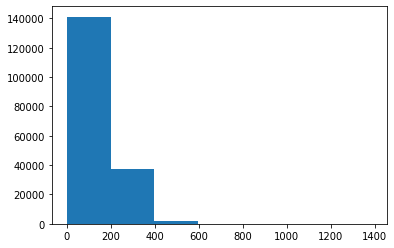

In [68]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [69]:
# Find out what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [70]:
# Get all keyboard charcaters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [71]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # plus 2 beacuse of spaces OOV token (OOV = out of vocab token ['UNK'])
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation", # with standardize set to "None", it includes the punctuation in vectorization
                                    name="char_vectorizer")

In [73]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [72]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least commmon characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 2
5 most common characters: ['', '[UNK]']
5 least commmon characters: ['', '[UNK]']


In [74]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized_chars: {len(vectorized_chars[0])}")

Charified text:
 i n   t h e   a c u p u n c t u r e - m o x i b u s t i o n   g r o u p   ,   a c u p u n c t u r e   w a s   a p p l i e d   t o   s h e n s h u   (   b l   @   )   ,   p a n g g u a n g s h u   (   b l   @   )   ,   z h o n g j i   (   c v   @   )   ,   g u a n y u a n   (   c v   @   )   a n d   s h u i d a o   (   s t   @   )   ,   a n d   t h e   w a r m   m o x i b u s t i o n   t h e r a p y   w i t h   m o x a   s t i c k   w a s   u s e d   a t   s h e n s h u   (   b l   @   )   ,   g u a n y u a n   (   c v   @   )   a n d   s h e n q u e   (   c v   @   )   ,   o n c e   e v e r y   d a y   .

Length of random_train_chars: 235

Vectorized chars:
 [[ 4  6  3 13  2  5 11 16 14 16  6 11  3 16  8  2 15  7 24  4 22 16  9  3
   4  7  6 18  8  7 16 14  5 11 16 14 16  6 11  3 16  8  2 20  5  9  5 14
  14 12  4  2 10  3  7  9 13  2  6  9 13 16 22 12 14  5  6 18 18 16  5  6
  18  9 13 16 22 12 25 13  7  6 18 27  4 11 21 18 16  5  6 19 16  5  6 11
  21  5  6 10  9 13 

## Creating a character-level embedding layer

In [75]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different char tokens
                              output_dim=25, # as per char embedding size in research paper
                              mask_zero=False,
                              name="char_embed")

In [76]:
# Test character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 i n   t h e   a c u p u n c t u r e - m o x i b u s t i o n   g r o u p   ,   a c u p u n c t u r e   w a s   a p p l i e d   t o   s h e n s h u   (   b l   @   )   ,   p a n g g u a n g s h u   (   b l   @   )   ,   z h o n g j i   (   c v   @   )   ,   g u a n y u a n   (   c v   @   )   a n d   s h u i d a o   (   s t   @   )   ,   a n d   t h e   w a r m   m o x i b u s t i o n   t h e r a p y   w i t h   m o x a   s t i c k   w a s   u s e d   a t   s h e n s h u   (   b l   @   )   ,   g u a n y u a n   (   c v   @   )   a n d   s h e n q u e   (   c v   @   )   ,   o n c e   e v e r y   d a y   .

Embedded chars. (after vectorization and embedding):
 [[[ 0.02610994 -0.04074083 -0.0437105  ...  0.03933356 -0.00586364
    0.02687612]
  [ 0.01217517 -0.0221789   0.01958478 ...  0.03967246 -0.03710346
   -0.02146137]
  [ 0.01245179 -0.02094177 -0.04032258 ... -0.02361969  0.02318886
    0.01145371]
  ...
  [ 0.02056536 -0.0361807  -0.03438811 ... -0.0459086   0.027

## Building Model 3: 

```
*# This is formatted as code*
```

a Conv1D Model to fit character level embeddings

In [77]:
# Create char embedding layer
char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(char_inputs) # vectorize char inputs
char_embeddings = char_embed(char_vectors) # create char embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x) # condense the output of feature vector from conv layer
char_outputs = layers.Dense(num_classes, activation="softmax")(x) # using softmax because there is multiclass classification
model_3 = tf.keras.Model(char_inputs, 
                         char_outputs,
                         name="model_3_conv1d_char_embeddings")

# compile 
model_3.compile(loss="categorical_crossentropy", # categorial_crossentropy becuase dealing with multiclass
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [78]:
# Summary Model 3
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

## Create char datasets

In [79]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [80]:
# Fit the model on chars only (10% of dataset)
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 10ms/step - loss: 1.2616 - accuracy: 0.4891 - val_loss: 1.0476 - val_accuracy: 0.5824
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 1.0097 - accuracy: 0.5935 - val_loss: 0.9352 - val_accuracy: 0.6400
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9283 - accuracy: 0.6353 - val_loss: 0.8686 - val_accuracy: 0.6639


In [81]:
# Evaluate model 3 on whole validation char data set
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8906 - accuracy: 0.6552


[0.8906171917915344, 0.6552032232284546]

In [82]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[0.14593177, 0.25271153, 0.1846772 , 0.31601697, 0.10066248],
       [0.20641966, 0.47264194, 0.03927185, 0.21063647, 0.07103015],
       [0.13639073, 0.28726178, 0.24616134, 0.25306007, 0.07712612],
       ...,
       [0.03548702, 0.04286928, 0.29083085, 0.06859576, 0.56221706],
       [0.0270741 , 0.12427838, 0.22731464, 0.14247341, 0.47885948],
       [0.40088394, 0.29762882, 0.20166872, 0.08555423, 0.01426431]],
      dtype=float32)

In [83]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 0])>

In [84]:
# Calculate results for Conv1D chars only model
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.52032305044352,
 'precision': 0.6522925890929084,
 'recall': 0.6552032305044353,
 'f1': 0.6467971769877094}

## Build Model 4: Combining pretrained token embeddings with character embeddings (hybrid embedding layer)
1. Create token-level embedding model (`similar to model_1`)
2. Create character-level embedding model (`similar to model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate layer (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) 
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output


In [85]:
# 1. Set up token inputs/model (functional api)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings) # paper uses 300 token embeddings, can always go higher and experiment
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=[1, ], dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (craete hypbrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

#4. Create output layers - adding in Dropout to help with overfitting, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat) # paper uses 10%
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense) # paper uses 10%, note this is a 2nd dropout layer as per paper
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

#5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [86]:
# Get a summary of Model 4
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

## Model 4: Plotting and visualizing

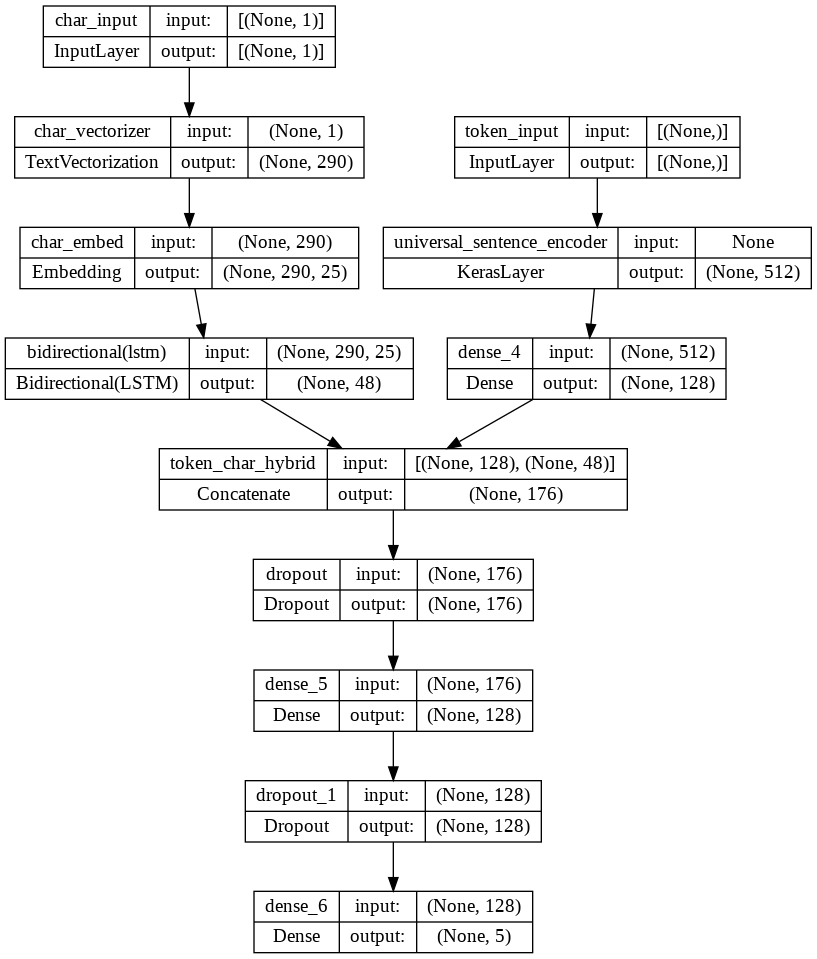

In [87]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [88]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper uses SGD
                metrics=["accuracy"])

## Combining token and character data into a tf.data Dataset

In [89]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [90]:
# Repeate the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [91]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [92]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 39ms/step - loss: 0.9917 - accuracy: 0.6054 - val_loss: 0.7969 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.8135 - accuracy: 0.6857 - val_loss: 0.7283 - val_accuracy: 0.7257
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7831 - accuracy: 0.7013 - val_loss: 0.7001 - val_accuracy: 0.7357


In [93]:
# Evaluate model 4 on whole validation set
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 21ms/step - loss: 0.7052 - accuracy: 0.7290


[0.7051985263824463, 0.7290480732917786]

In [94]:
# Make prediction probabilities using the token-character hybrid model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 20s 20ms/step


array([[3.6519042e-01, 4.3230501e-01, 5.3282878e-03, 1.8626003e-01,
        1.0916188e-02],
       [2.4602950e-01, 5.3275794e-01, 2.8775048e-03, 2.1625428e-01,
        2.0807940e-03],
       [2.8976607e-01, 1.5599325e-01, 4.3348897e-02, 4.7135380e-01,
        3.9537989e-02],
       ...,
       [4.8699876e-04, 6.1447010e-03, 4.4643946e-02, 1.2925804e-04,
        9.4859517e-01],
       [6.8877419e-03, 4.5219921e-02, 2.1408264e-01, 4.1109021e-03,
        7.2969884e-01],
       [4.8625761e-01, 2.4384873e-01, 1.8313605e-01, 4.2375114e-02,
        4.4382438e-02]], dtype=float32)

In [95]:
# Convert predictions probabilities into labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [96]:
# Get results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 72.90480603733616,
 'precision': 0.729760732342374,
 'recall': 0.7290480603733616,
 'f1': 0.7258389669424753}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings


> **Note:** Any engineered features used to train a model need to be avaialable at test time, in our case line numbers and total lines are available


### Create positional embeddings

In [97]:
# How many different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

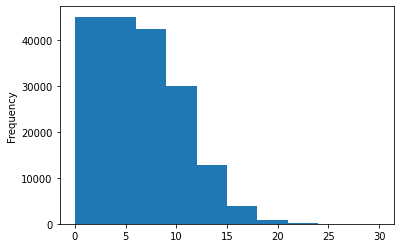

In [98]:
# Check the distribution of "line_numbers"
train_df.line_number.plot.hist()

In [99]:
# Use TensorFlow to create one-hot-encoded tensors of our line column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [100]:
# Encode total lines feature
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

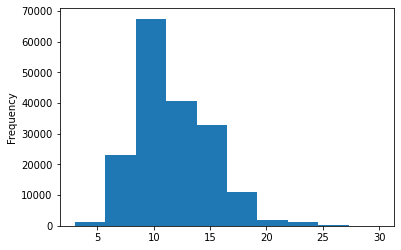

In [101]:
# Check distributions of total lines
train_df.total_lines.plot.hist();

In [102]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # can change percentages to find and test different values for total lines

20.0

In [103]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [109]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

#2. Character-level inputs
char_inputs = layers.Input(shape=[1, ], dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
# dense layer with 32 units & rulu activation
# combine inputs & dense layer into model
line_number_inputs = layers.Input(shape=[15, ], dtype=tf.float32, name="line_number_inputs")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_outputs)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=[20, ], dtype=tf.float32, name="total_lines_inputs")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=total_lines_outputs)

# 5. Combine token and char embeddings into hypbrid embedding and add Dropout
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output, 
                                                                                 total_lines_model.output,
                                                                                 z])
# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.inputs,
                                 total_lines_model.input,
                                 token_model.inputs,
                                 char_model.inputs],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")


In [110]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

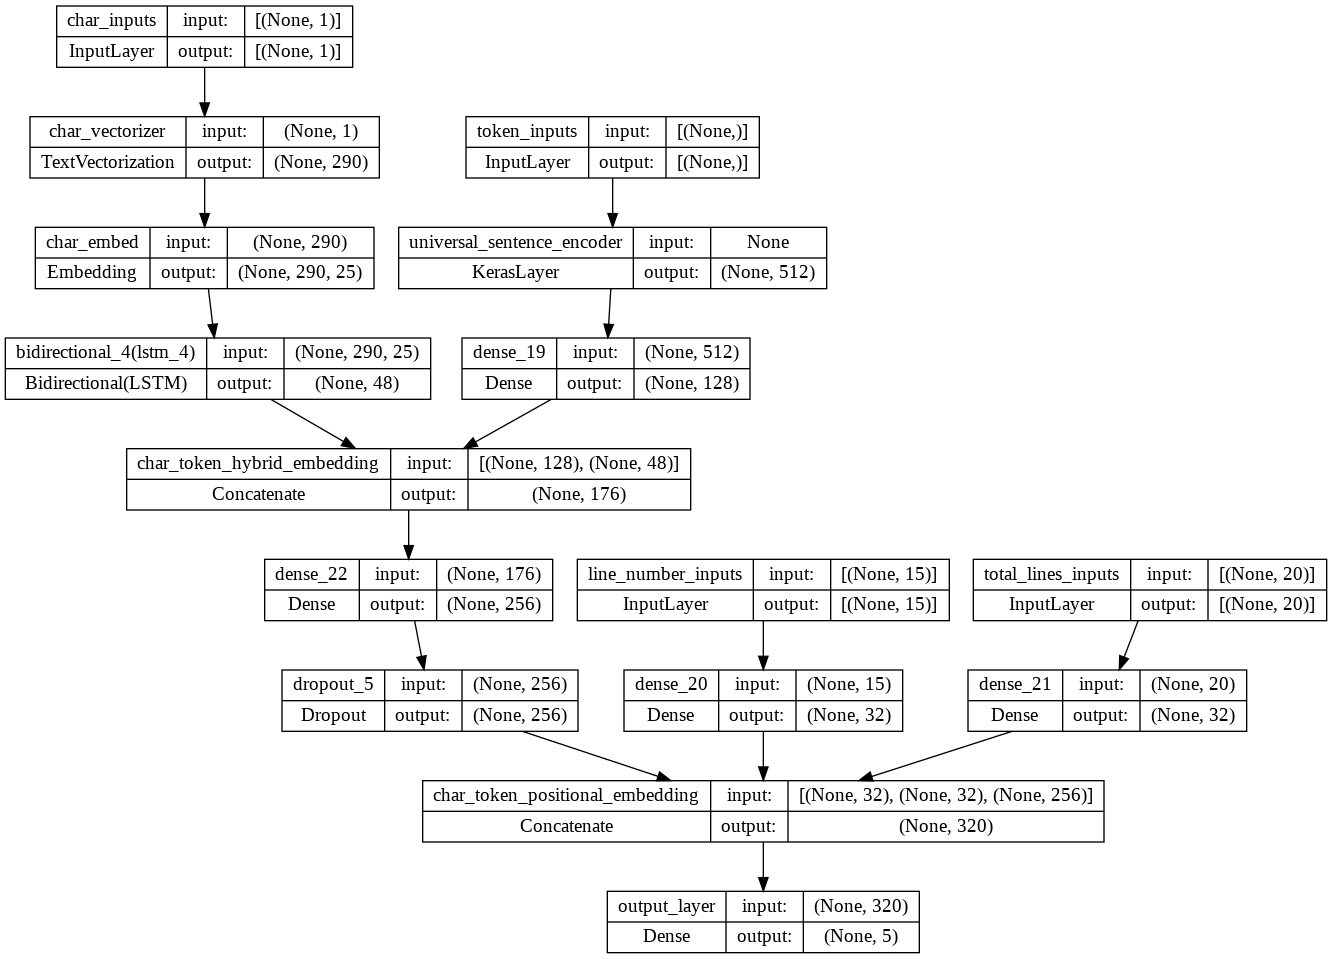

In [111]:
# Plot model architecture for model 5
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class(e.g. its predcition probability is really high), it may get stuck on that class and not consider other classess...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: [0.01, 0.01, 0.96, 0.01, 0.01]

> **Resource:** for more on label smoothing, see this blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [113]:
# Compile token, char, and positional embedding model (incoroporate label smoothign)
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data
1. Make data
2. Make labels
3. Combine data and labels
4. Prefectch data and batch train data

In [116]:
# Combining line_number_model.inputs, total_lines_model.input, token_model.inputs, char_model.inputs
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences, 
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [119]:
# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [120]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with the Model 5 tribrid model

In [121]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 42ms/step - loss: 1.1035 - accuracy: 0.7227 - val_loss: 0.9853 - val_accuracy: 0.8035
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9686 - accuracy: 0.8163 - val_loss: 0.9478 - val_accuracy: 0.8295
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9503 - accuracy: 0.8215 - val_loss: 0.9401 - val_accuracy: 0.8321


In [122]:
# Make predictions with tribrid model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 [==============================] - 20s 20ms/step


array([[0.5106585 , 0.11078498, 0.0095692 , 0.35281327, 0.01617409],
       [0.53697056, 0.11277092, 0.04479229, 0.29468316, 0.01078312],
       [0.2647769 , 0.11329204, 0.10997442, 0.4339988 , 0.07795791],
       ...,
       [0.0353028 , 0.09404651, 0.03468158, 0.03407337, 0.80189574],
       [0.02785643, 0.23035136, 0.05655354, 0.02664696, 0.65859175],
       [0.21905294, 0.5733657 , 0.10780687, 0.04333139, 0.0564431 ]],
      dtype=float32)

In [123]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [125]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.15569972196478,
 'precision': 0.830368709344533,
 'recall': 0.8315569972196478,
 'f1': 0.8304998845866497}

## Compare model results

In [126]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_tribrid_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.544949,0.782265,0.785449,0.783058
model_2_pretrained_token_embedding,71.299484,0.713153,0.712995,0.709835
model_3_custom_char_embedding,65.520323,0.652293,0.655203,0.646797
model_4_hybrid_char_token_embedding,72.904806,0.729761,0.729048,0.725839
model_5_tribrid_embedding,83.155700,0.830369,0.831557,0.830500


In [128]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

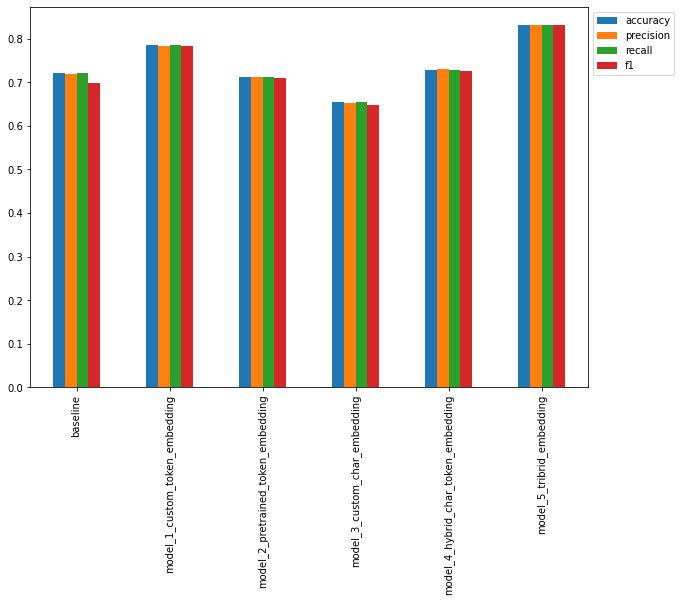

In [129]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

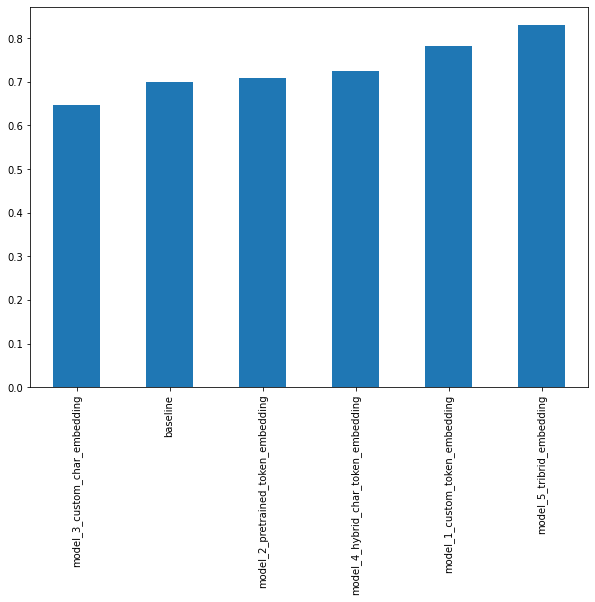

In [130]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load model 5

In [131]:
# Save the best performing model to SavedModel format (default)
model_5.save("absCat_tribrid_model")

In [135]:
from google.colab import files
files.download('absCat_tribrid_model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [144]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model_5.save('saved_model/absCat_tribrid_model_save') 

In [133]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("absCat_tribrid_model")

In [138]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 21s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [139]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.15569972196478,
 'precision': 0.830368709344533,
 'recall': 0.8315569972196478,
 'f1': 0.8304998845866497}

In [136]:
model_5_results

{'accuracy': 83.15569972196478,
 'precision': 0.830368709344533,
 'recall': 0.8315569972196478,
 'f1': 0.8304998845866497}

In [141]:
model_5_results == loaded_model_results

True

In [142]:
assert model_5_results == loaded_model_results

In [143]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t